In [1]:
import numpy as np
import scipy
import scipy.sparse.linalg as LA
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh  # For sparse diagonalization
from numpy.linalg import eigh  # For small systems
import matplotlib.pyplot as plt

In [2]:
# Pauli matrices
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
id2 = np.eye(2, dtype=complex)


def build_operator(op, i, N):
    #Builds a many-body operator acting with op on site i
    tmp = 1
    for j in range(N):
        tmp = kron(tmp, op if i == j else id2, 'csr')
    return tmp


def ising_hamiltonian(N, J=1.0, h=1.0, periodic=True, sparse=True):
    # Constructs the TFIM Hamiltonian for N spins
    H = 0
    # Interaction terms: -J * sz_i * sz_{i+1}
    for i in range(N):
        j = (i + 1) % N if periodic else i + 1
        if j >= N:
            continue
        sz_i = build_operator(sz, i, N)
        sz_j = build_operator(sz, j, N)
        H += -J * (sz_i @ sz_j)

    # Transverse field terms: -h * sx_i
    for i in range(N):
        sx_i = build_operator(sx, i, N)
        H += -h * sx_i

    return H if sparse else H.toarray()


def expm_H(Es, U, t):
  # Returns e^{-iHt}
  tmp = U @ np.diag(np.exp(-1j*t*Es)) @ np.conjugate(np.transpose(U))
  return tmp


def trace_distance(rho1, rho2):
  # Returns trace distance of rho1 and rho2
  val = 1/2*np.sum(np.linalg.svdvals(rho1 - rho2))
  return val


In [4]:
# Parameters
N = 6         # Number of spins (keep small for exact diagonalization)
J = 1.0       # Ising coupling
h = 1.4       # Transverse field

# Build Hamiltonian
H = ising_hamiltonian(N, J, h, periodic=True, sparse=False)

# Diagonalize Hamiltonian
Es, U = eigh(H)             # H = U @ Es @ U^\dag
print("Eigenvalues:")
print(np.round(Es, 6))

# Construt ground state density matrix
spectral_gap =  Es[1] - Es[0]
ground_state = U[:,0]
ground_state_rho = np.outer(ground_state, np.conjugate(np.transpose(ground_state)))

Eigenvalues:
[-9.545045 -8.674122 -6.976123 -6.976123 -6.618945 -5.297999 -5.297999
 -4.674122 -4.641065 -4.641065 -4.641065 -4.641065 -3.678123 -3.44093
 -3.44093  -3.44093  -3.44093  -2.663185 -2.       -2.       -2.
 -2.       -1.46305  -1.46305  -1.46305  -1.46305  -1.376123 -1.376123
 -0.321877 -0.302001 -0.302001 -0.262915  0.262915  0.302001  0.302001
  0.321877  1.376123  1.376123  1.46305   1.46305   1.46305   1.46305
  2.        2.        2.        2.        2.663185  3.44093   3.44093
  3.44093   3.44093   3.678123  4.641065  4.641065  4.641065  4.641065
  4.674122  5.297999  5.297999  6.618945  6.976123  6.976123  8.674122
  9.545045]


In [5]:
# Random initial state
init_state = np.random.rand(2**N) + 1j*np.random.rand(2**N)
init_state *= 1/np.linalg.norm(init_state)

In [6]:
# Imaginary-time evolved state
beta = 2
ITE_state = scipy.linalg.expm(-beta*H) @ init_state
ITE_state *= 1/np.linalg.norm(ITE_state)
ITE_state_rho = np.outer(ITE_state, np.conjugate(np.transpose(ITE_state)))

In [7]:
# Trace distance between ITE state and ground state
trace_distance(ITE_state_rho, ground_state_rho)

np.float64(0.013970350694707492)

In [8]:
# Estimates the randomly-compiled real-imaginary time evolved state by averaging over M samples

M = int(1e5)                        # Number of samples
sigma = 3*(beta/spectral_gap)**.5   # Standard deviation; in general this should be O(\sqrt{beta/Delta}) for a Gaussian distribution

ts = np.random.normal(0, sigma, M)  # Times sampled from Gaussian distribution with stdev sigma

RC_ITE_state_rho = np.zeros((2**N, 2**N) , dtype=complex)     # Initializes randomly-compiled ITE state

U_dag_ITE_state = np.conjugate(np.transpose(U)) @ ITE_state   # U_dag times ITE state (this is used below in estimating RC ITE states)

for m in range(M):
  if m % (10000) == 0:
    print(m)

  t = ts[m]

  # H = U @ Es @ U^\dag, so the real-time evolution operator can be written as U @ exp(-1j*t*Es) @ U^\dag.
  # We use this to realize a single real-imaginary time evolved state vector as a sequence of many matrix-vector multiplications
  tmp = U @ (np.diag(np.exp(-1j*t*Es)) @ U_dag_ITE_state)     # Real-imaginary time evolved state vector
  tmp_rho = np.outer(tmp, np.conjugate(np.transpose(tmp)))    # Real-imaginary time evolved state density matrix

  # Do the same thing, but now with -t. This enforces that sampling of times t is done symmetrically about 0
  tmp2 = U @ (np.diag(np.exp(1j*t*Es)) @ U_dag_ITE_state)
  tmp2_rho = np.outer(tmp2, np.conjugate(np.transpose(tmp2)))

  RC_ITE_state_rho += 1/2*(tmp_rho + tmp2_rho)

# Average all sampled states
RC_ITE_state_rho *= 1/M

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [1]:
#Evaluate trace distance with ground state
trace_distance(RC_ITE_state_rho, ground_state_rho)

NameError: name 'trace_distance' is not defined

# Plot Data

In [10]:
# Data I collected
betas = np.array([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
ITE_TD = np.array([0.120006941,0.029359188,0.009365511,0.0046932,0.002902611,0.00186637,0.001206503,0.000780483,0.000504939,0.000326678])
RC_ITE_TD = np.array([0.014748462,0.000903409,9.08081E-05,2.25486E-05,1.01104E-05,3.69474E-06,1.77158E-06,9.63414E-07,4.56215E-07,2.36795E-07])
RC_ITE_TD_stdev = np.array([5.64657E-06,4.52879E-06,1.26487E-06,5.26862E-07,1.31866E-06,3.60074E-07,2.63238E-07,2.54559E-07,1.36589E-07,6.21586E-08])

Text(0.5, 1.0, 'Trace Distance vs. beta')

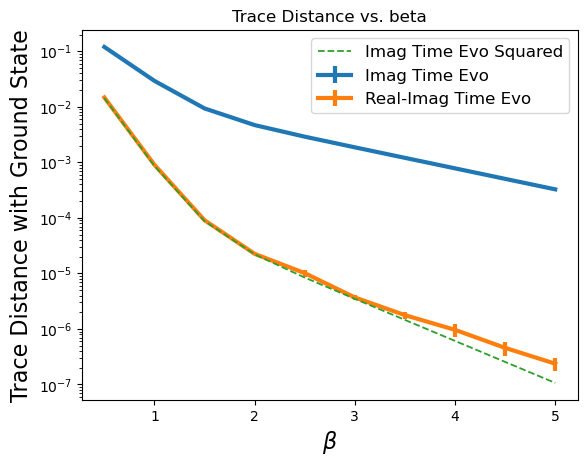

In [11]:
# Plot data
plt.errorbar(betas, ITE_TD, 0*RC_ITE_TD_stdev, label='Imag Time Evo', linewidth = 3)
plt.errorbar(betas, RC_ITE_TD, RC_ITE_TD_stdev, label='Real-Imag Time Evo', linewidth = 3)
plt.plot(betas, ITE_TD**2, label='Imag Time Evo Squared', linewidth = 1.3, linestyle='--', zorder=3)

plt.yscale('log')
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'Trace Distance with Ground State', fontsize=16)
plt.legend(fontsize = 12)
plt.title('Trace Distance vs. beta')